# Cell Communities exploration

In [85]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from anndata import AnnData

In [86]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [87]:
# data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/SS200000135TL_D1_with_annotation.h5ad'
# annotation_label = 'celltype_pred'
data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/E16.5_E1S3_cell_bin_whole_brain_spagft_4.h5ad'
annotation_label = 'sim anno'
adata = sc.read(data_path)

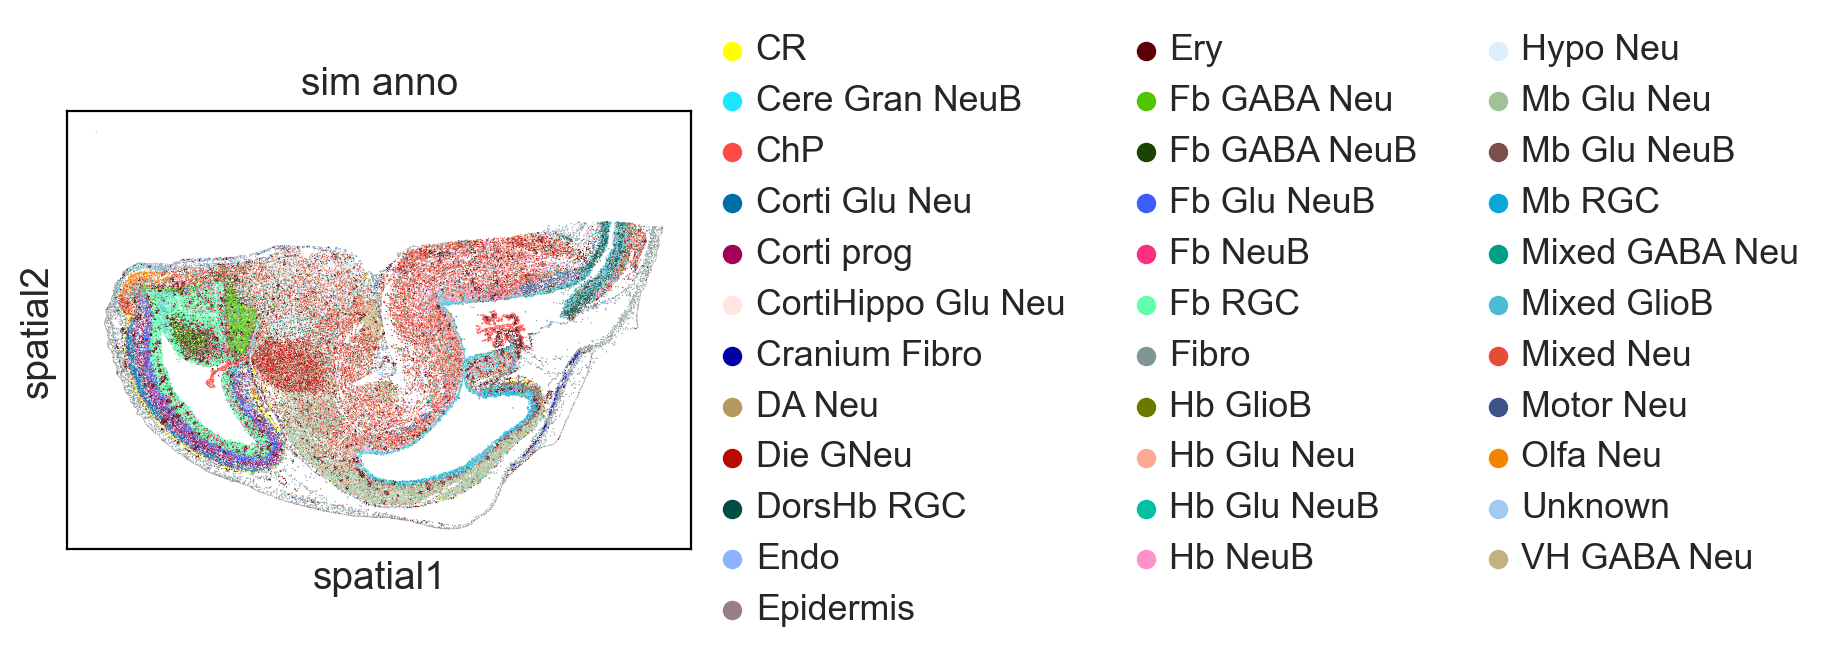

In [88]:
sc.pl.spatial(adata, color=annotation_label, palette=list(adata.uns[f'{annotation_label}_colors']), spot_size=30)

# Sliding window

In [89]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, sliding_step = None, resolution=0.2):

    # bin size needs to be a multiple of sliding step
    sliding_step = (bin_size/int((bin_size/sliding_step))) if sliding_step!=None else bin_size
    bin_slide_ratio = int(bin_size/sliding_step)

    # create centroids for each sliding step of windows
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0])/sliding_step).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1])/sliding_step).astype(int)
    # need to understand borders and padding
    # subwindows belonging to borders will not have a complete cell count
    x_max = adata1.obs['Centroid_X'].max()
    y_max = adata1.obs['Centroid_Y'].max()
    x_min = adata1.obs['Centroid_X'].min()
    y_min = adata1.obs['Centroid_Y'].min()

    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
    ret = {}
    # calculate features for each subwindow
    for sw_ind, sw_data in tmp.groupby('x_y'):
        templete_dic = {ct:0 for ct in tmp[use_col].cat.categories}
        for cell in sw_data[use_col]:
            templete_dic[cell]+=1
        ret[sw_ind] = templete_dic
    # merge features by windows
    feature_matrix = {}
    for subwindow in ret.keys():
        # index of window is in the top left corner of the whole window
        feature_matrix[subwindow] = {}
        x_curr = int(subwindow.split("_")[0])
        y_curr = int(subwindow.split("_")[1])
        # count the number of subwindows participating in full window feature vec
        num_subw = 0

        for slide_x in range(0, np.min([bin_slide_ratio, x_max-x_curr+1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_max-y_curr+1])):  # starts from 1 since values with coordinates (0,0) are already written by initializing with ret[subwindow]
                if (f'{x_curr + slide_x}_{y_curr + slide_y}') in ret.keys():
                    num_subw += 1
                    feature_matrix[subwindow] = {k: 
                                                feature_matrix[subwindow].get(k, 0) + ret[f'{x_curr + slide_x}_{y_curr + slide_y}'].get(k, 0)
                                                for k in set(feature_matrix[subwindow]).union(ret[f'{x_curr + slide_x}_{y_curr + slide_y}'])}
        # # scale the feature values by the number of summed subwindows that form it (it could be useful as feature vector normalization)
        # feature_matrix[subwindow] = {k:feature_matrix[subwindow][k]/num_subw for k in feature_matrix[subwindow].keys()}

    feature_matrix = pd.DataFrame(feature_matrix).T
    tissue = AnnData(feature_matrix)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in feature_matrix.index]).astype(int)
    sc.pp.neighbors(tissue, use_rep='spatial')

    tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    # sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=resolution)

    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the top left corner of the whole window
        subwindow_labels = {}
        for slide_x in range(0, np.min([bin_slide_ratio, x_curr - x_min + 1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_curr - y_min + 1])):
                # check if location exist (spatial area is not complete)
                if (f'{x_curr - slide_x}_{y_curr - slide_y}') in tissue.obs.index:
                    new_value = tissue.obs.loc[f'{x_curr - slide_x}_{y_curr - slide_y}', 'leiden']
                    subwindow_labels[new_value] = subwindow_labels[new_value] + 1 if new_value in subwindow_labels.keys() else 1
        
        # max vote
        # max vote should be saved in a new obs column so that it does not have diagonal effect on
        # other labels during refinment
        tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)


    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata1.obs['tissue_sliding_leiden'] = list(tissue.obs.loc[adata1.obs['x_y'], 'leiden_refined'])

    return tissue

In [6]:
adata

AnnData object with n_obs × n_vars = 49921 × 22404
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'psuedo_class', 'celltype_pred', 'morpho_featureID', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Exp', 'Pos', 'celltype_pred_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'psuedo_classes'
    obsm: 'X_pca', 'cell_seg_feature', 'psuedo_label', 'spatial'
    obsp: 'Combined_connectivities', 'Exp_connectivities', 'Exp_distances', 'Im_connectivities', 'Im_distances', 'Pos_connectivities', 'Pos_distances', 'connectivities'

In [90]:
# define if only cell types with more than 100 cells are used for cell communities extraction
more_than_100 = False
if more_than_100:

    cell_over_100 = []
    for cell_tp in adata.obs[annotation_label].cat.categories:
        cell_num = sum(adata.obs[annotation_label]==cell_tp)
        if cell_num > 100:
            cell_over_100.append(cell_tp)

    adata = adata[adata.obs[annotation_label].isin(cell_over_100),:]

In [91]:
tissue = tissue_cluster(adata1=adata, use_col=annotation_label, bin_size=150, moran_thres=-1, sliding_step=50, resolution=0.1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_23848/1681325082.py:48: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(feature_matrix)


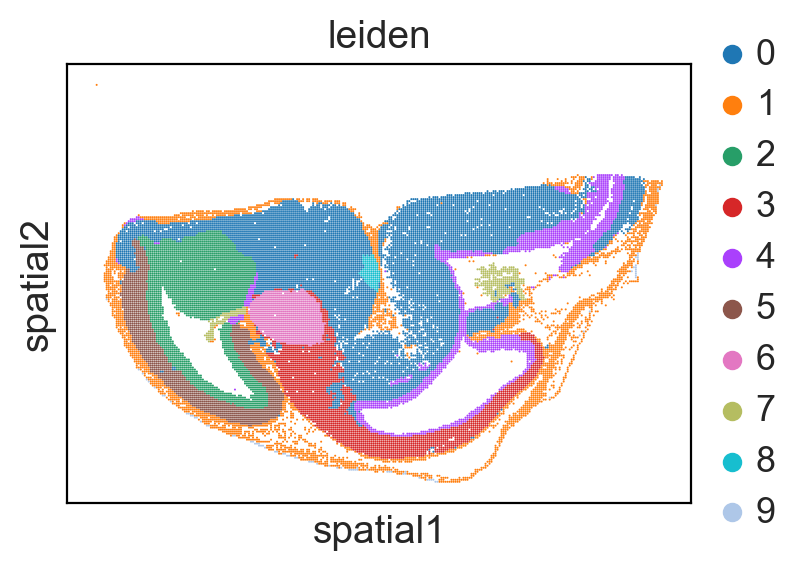

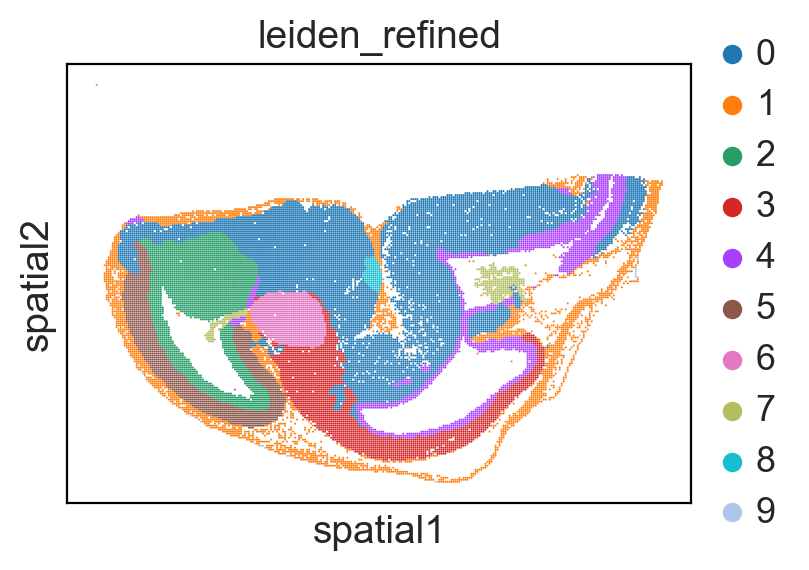

In [92]:
# plot initial clustering for each window
sc.pl.spatial(tissue, color='leiden', spot_size=1)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', spot_size=1)

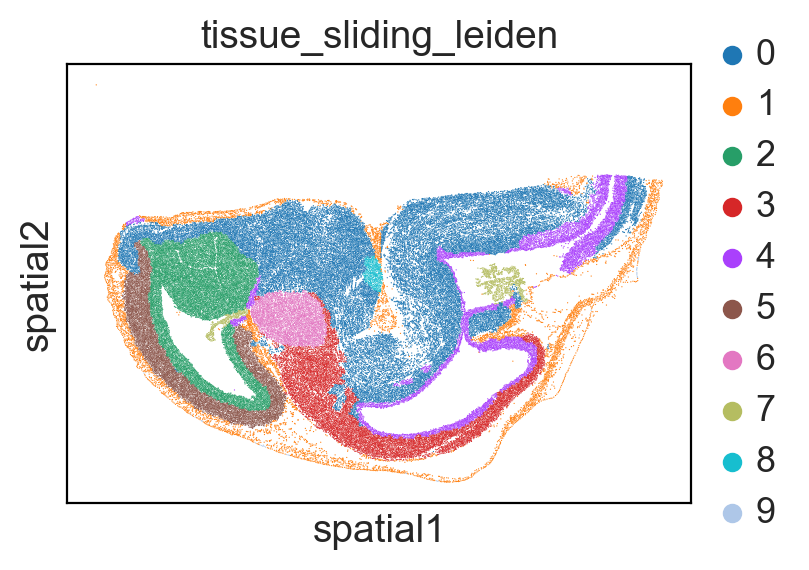

In [93]:
# plot final clustering in cell resolution
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.spatial(adata, color='tissue_sliding_leiden', spot_size=30)

## Cell community statistics

In [94]:
# extract information on leiden clustering labels and cell types to create cell communities statistics
clustering_labels = 'tissue_sliding_leiden'
cell_types_col = annotation_label
cell_types_communities = adata.obs[[clustering_labels, cell_types_col]]

stats_table = {}
# calculate cell type mixtures for every cluster
for label, cluster_data in cell_types_communities.groupby(clustering_labels):
    cell_type_dict = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
    for cell in cluster_data[cell_types_col]:
        cell_type_dict[cell]+=1
    total_cluster_cells = sum(cell_type_dict.values())
    # stats_table[label] = {ct:int(cell_type_dict[ct]/total_cluster_cells*100) for ct in cell_type_dict.keys()}
    stats_table[label] = {ct:cell_type_dict[ct] for ct in cell_type_dict.keys()}

    stats_table[label]['total_counts'] = int(sum(cell_type_dict.values()))



stats = pd.DataFrame(stats_table).T
# stats.index.name='clusters'
stats.columns.name="cell types"

# add final row with total counts per cell types
cell_type_counts = {ct:[int(sum(stats[ct].values))] for ct in cell_types_communities[cell_types_col].cat.categories}
stats = pd.concat([stats, pd.DataFrame(cell_type_counts, index=['total_cells'])])






In [95]:
stats

CR  Cere Gran NeuB  ChP  Corti Glu Neu  Corti prog  \
0             46             165    0             42           2   
1            171               2    5              3           1   
2             75              16    0             18          10   
3             37              11    0              0           0   
4              5              20    0              2           0   
5            171               0    0           1396        1292   
6              5               2    0              0           0   
7              0               0  653              0           0   
8              5               0    0              0           0   
9              0               0    0              0           0   
total_cells  515             216  658           1461        1305   

             CortiHippo Glu Neu  Cranium Fibro  DA Neu  Die GNeu  DorsHb RGC  \
0                           202              2     307      2018         294   
1                            27            197       2         4          19   
2                            53              2       0         0           8   
3                            30              0      17       364           5   
4                            17              1       2        12        1124   
5                           847              0       0         7           0   
6                             4              0       4      1836           1   
7                             0              0       0         0           1   
8                             0              0       2         9           0   
9                             0              0       0         0           0   
total_cells                1180            202     334      4250        1452   

             ...  Mb Glu NeuB  Mb RGC  Mixed GABA Neu  Mixed GlioB  Mixed Neu  \
0            ...          147      11             967          200       8006   
1            ...           64      23               9           54        125   
2            ...           38      54               9          247        120   
3            ...          290      37              82            4        908   
4            ...          174     836              15         2010        181   
5            ...           69       2               6            0        148   
6            ...            1       0               3            0         68   
7            ...            0       2               0            7          0   
8            ...            2       0               0            0         38   
9            ...            0       0               0            0          0   
total_cells  ...          785     965            1091         2522       9594   

             Motor Neu  Olfa Neu  Unknown  VH GABA Neu  total_counts  
0                  114       428      306         1148       25491.0  
1                    1         3       28            7        6292.0  
2                    0         1       54            1        9683.0  
3                    1        17       73           88        7629.0  
4                  383         5       91            7        6278.0  
5                    0         3       23            3        5700.0  
6                    2         1        4           12        2769.0  
7                    0         0        1            0         988.0  
8                    0         0        5          291         439.0  
9                    0         0        0            0          34.0  
total_cells        501       458      585         1557           NaN  

[11 rows x 35 columns]

In [96]:
# divide each row with total sum of cells per cluster
for i in range(len(stats.index.values[:-1])):
    stats.iloc[i, :-1] = (100 * stats.iloc[i, :-1] / stats.iloc[i, -1]).astype(int)

In [97]:
stats

CR  Cere Gran NeuB  ChP  Corti Glu Neu  Corti prog  \
0              0               0    0              0           0   
1              2               0    0              0           0   
2              0               0    0              0           0   
3              0               0    0              0           0   
4              0               0    0              0           0   
5              3               0    0             24          22   
6              0               0    0              0           0   
7              0               0   66              0           0   
8              1               0    0              0           0   
9              0               0    0              0           0   
total_cells  515             216  658           1461        1305   

             CortiHippo Glu Neu  Cranium Fibro  DA Neu  Die GNeu  DorsHb RGC  \
0                             0              0       1         7           1   
1                             0              3       0         0           0   
2                             0              0       0         0           0   
3                             0              0       0         4           0   
4                             0              0       0         0          17   
5                            14              0       0         0           0   
6                             0              0       0        66           0   
7                             0              0       0         0           0   
8                             0              0       0         2           0   
9                             0              0       0         0           0   
total_cells                1180            202     334      4250        1452   

             ...  Mb Glu NeuB  Mb RGC  Mixed GABA Neu  Mixed GlioB  Mixed Neu  \
0            ...            0       0               3            0         31   
1            ...            1       0               0            0          1   
2            ...            0       0               0            2          1   
3            ...            3       0               1            0         11   
4            ...            2      13               0           32          2   
5            ...            1       0               0            0          2   
6            ...            0       0               0            0          2   
7            ...            0       0               0            0          0   
8            ...            0       0               0            0          8   
9            ...            0       0               0            0          0   
total_cells  ...          785     965            1091         2522       9594   

             Motor Neu  Olfa Neu  Unknown  VH GABA Neu  total_counts  
0                    0         1        1            4       25491.0  
1                    0         0        0            0        6292.0  
2                    0         0        0            0        9683.0  
3                    0         0        0            1        7629.0  
4                    6         0        1            0        6278.0  
5                    0         0        0            0        5700.0  
6                    0         0        0            0        2769.0  
7                    0         0        0            0         988.0  
8                    0         0        1           66         439.0  
9                    0         0        0            0          34.0  
total_cells        501       458      585         1557           NaN  

[11 rows x 35 columns]

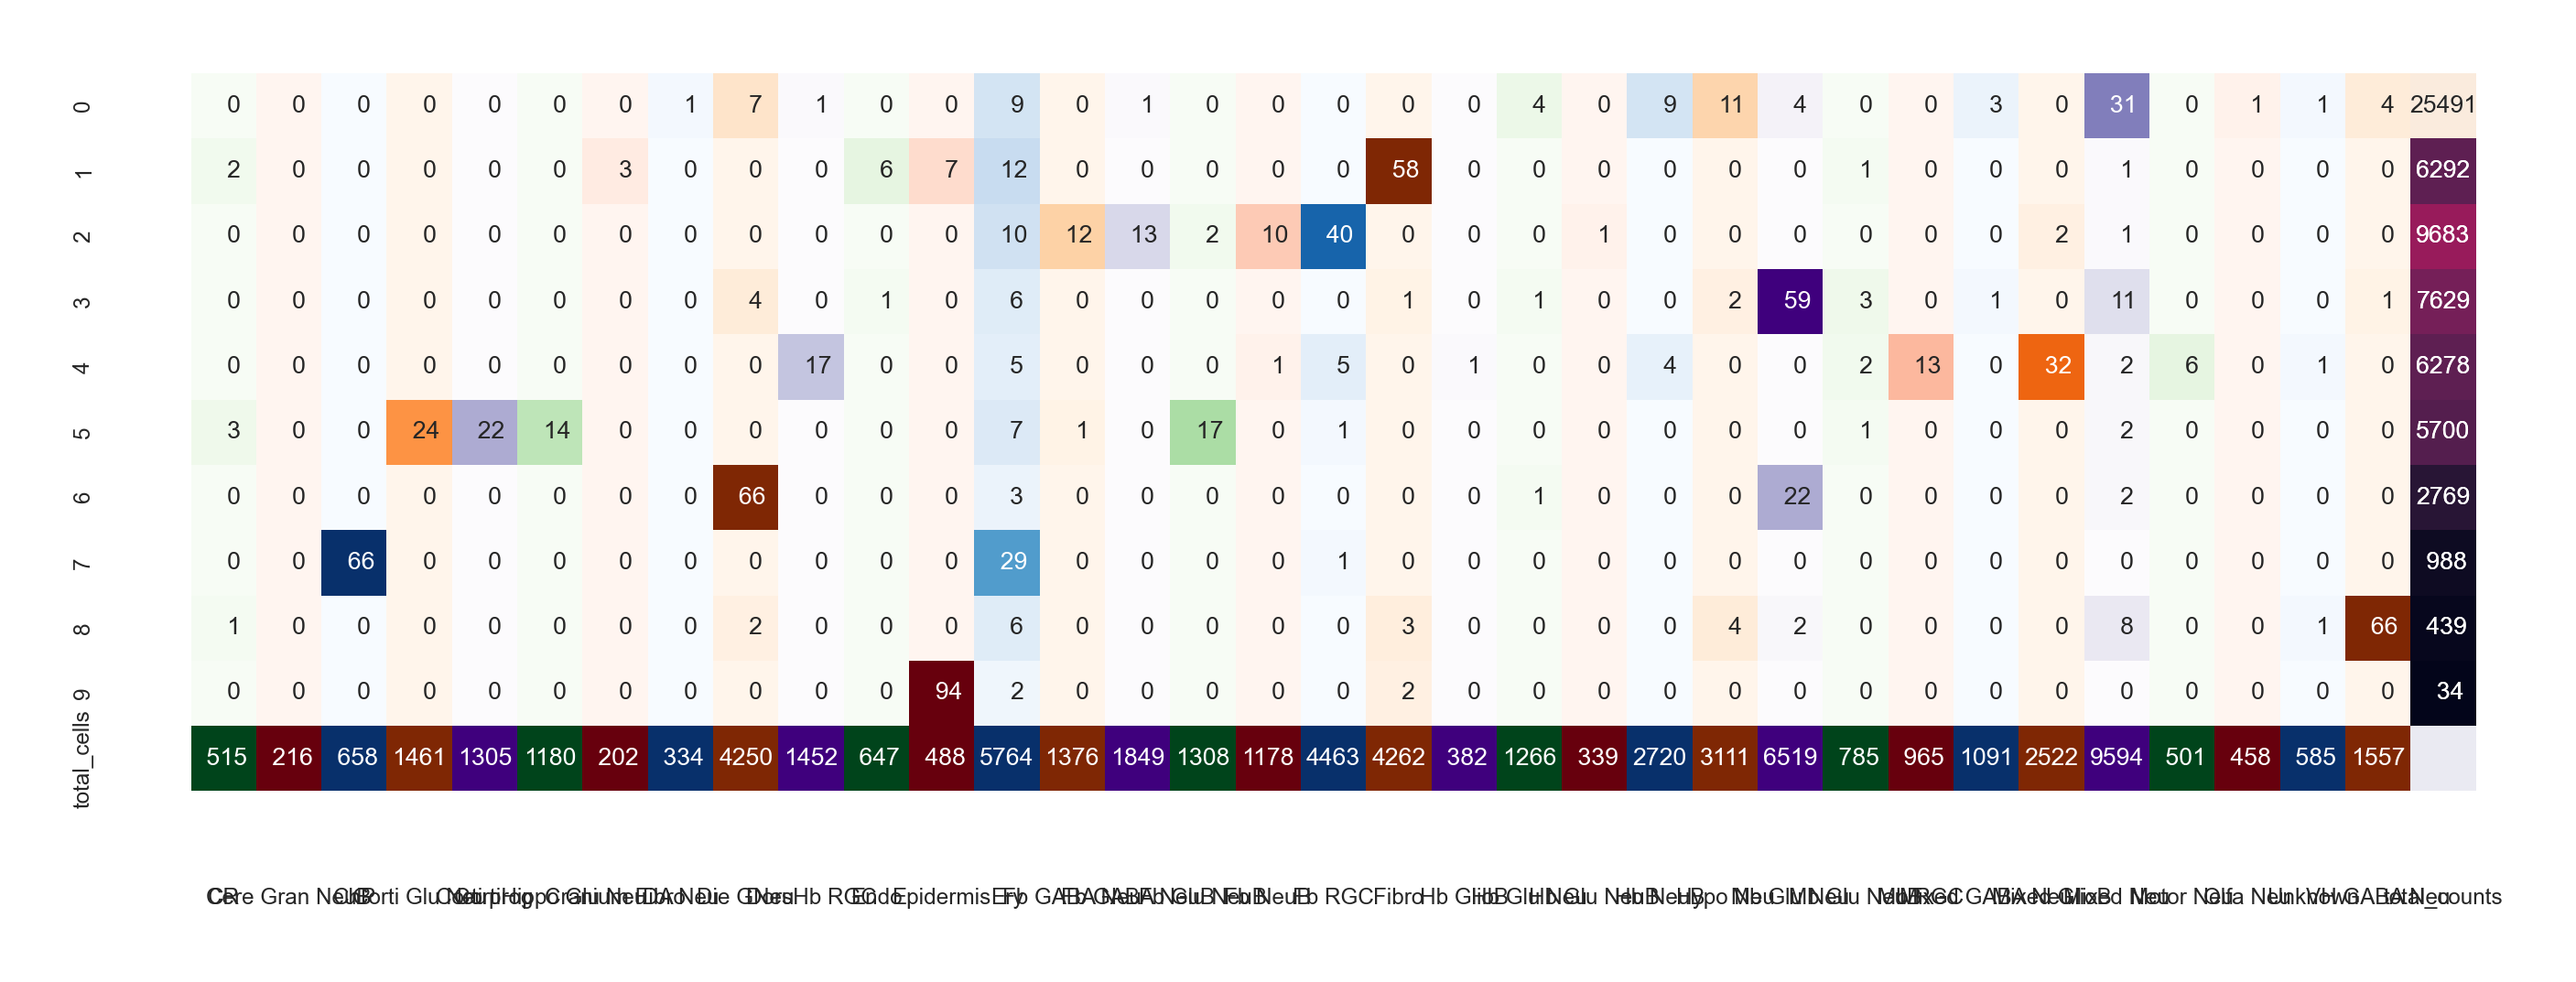

In [98]:
from matplotlib import pyplot as plt
from itertools import cycle
sc.settings.set_figure_params(dpi=400, facecolor='white')
sns.set(font_scale=0.2)

ncols = len(stats.columns) # we want to separately print the total_counts column
fig, axes = plt.subplots(ncols=ncols)

# no space between columns
fig.subplots_adjust(wspace=0)

# put colormaps of your choice in a list:
cmap_cycle = cycle(['Greens', 'Reds', 'Blues', 'Oranges', 'Purples'])

annotation_keywords = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
x_labels = [x for x in cell_types_communities[cell_types_col].cat.categories]

for i, ax in enumerate(axes):
    sns.heatmap(pd.DataFrame(stats.iloc[:, i]), vmin=0.0, vmax=50, linewidths=0, linecolor=None, annot=True, cbar=False, ax=ax, cmap=cmap_cycle.__next__(),fmt='4.0f', xticklabels=True, yticklabels=True if i==0 else False, square=True)
# final column should have the sum of all cells per cluster
sns.heatmap(pd.DataFrame(stats.iloc[:, -1]), annot=True, linewidths=0, linecolor=None, cbar=False, cmap=None, ax=ax, fmt='4.0f', xticklabels=True, yticklabels=False, square=True)

plt.show()

### main cell types per cluster

### cluster 2, 9, 11, 13

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


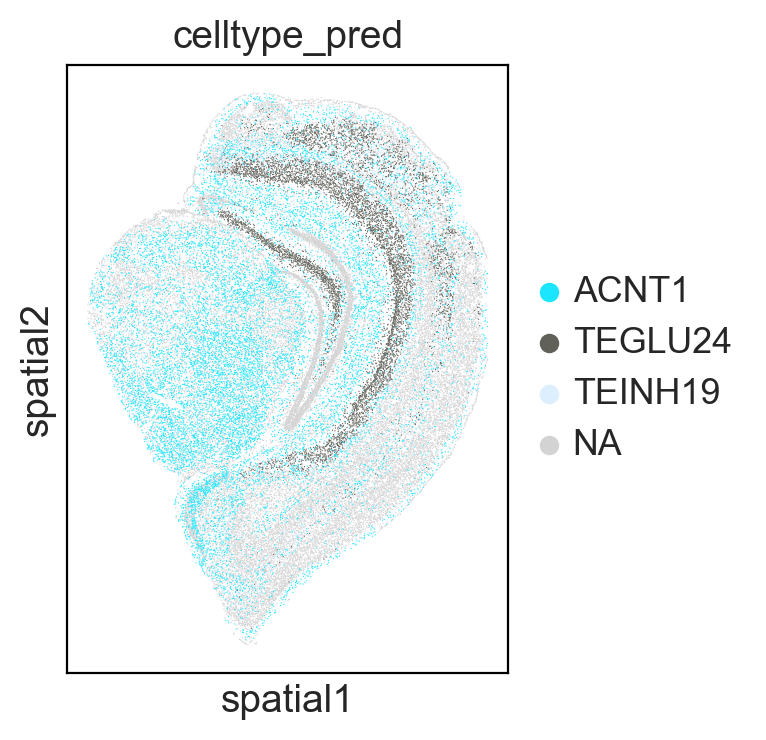

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


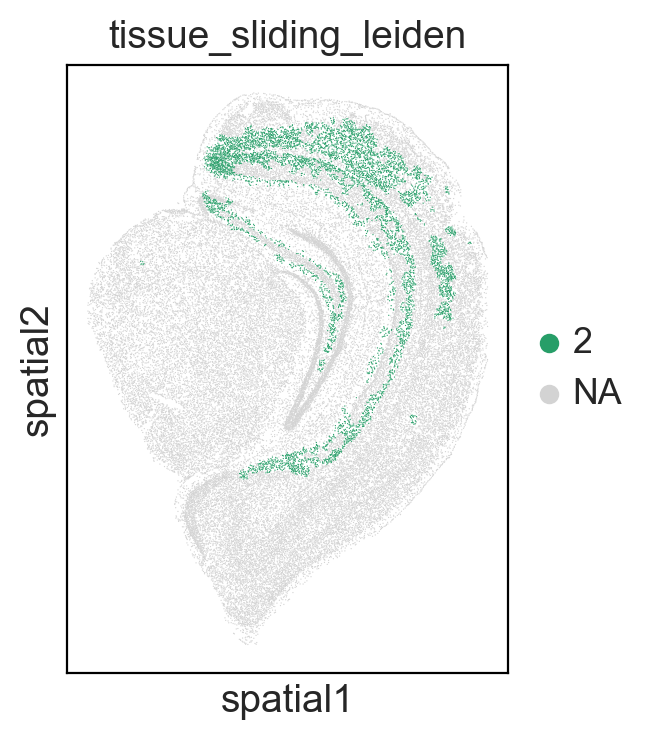

In [18]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster2 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[23]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[31]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[23], stats.columns[31]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['2'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


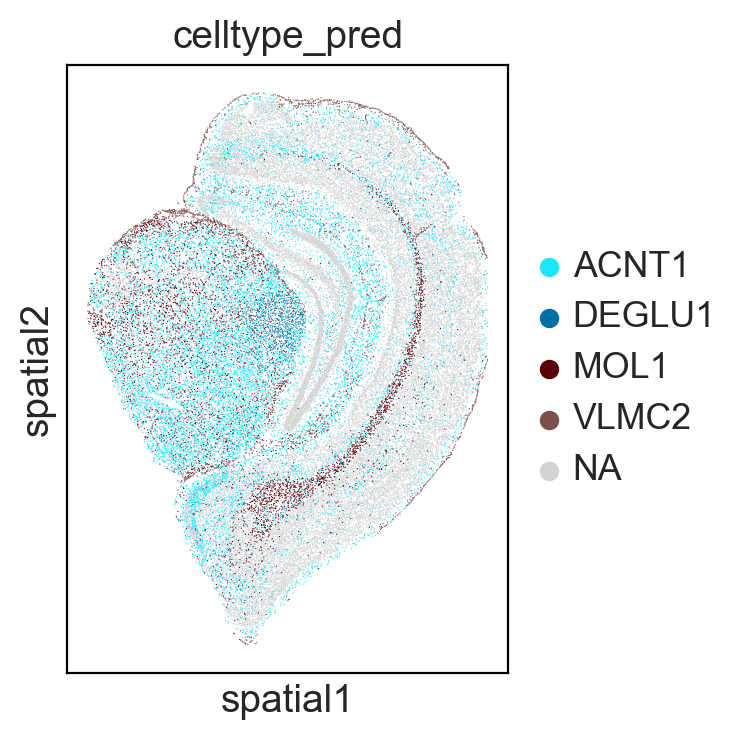

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


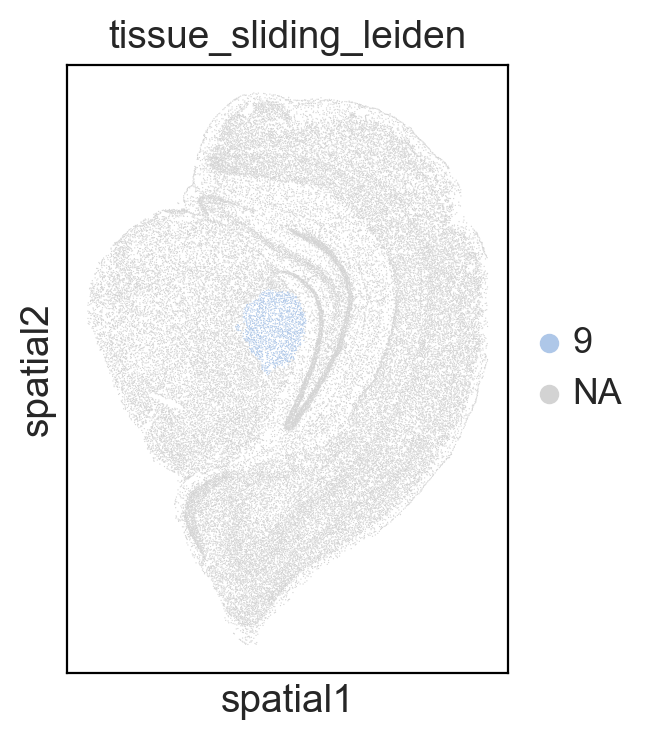

In [19]:
# plot cells of cluster 9 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster9 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[5]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[15]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[33]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[5], stats.columns[15], stats.columns[33]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['9'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


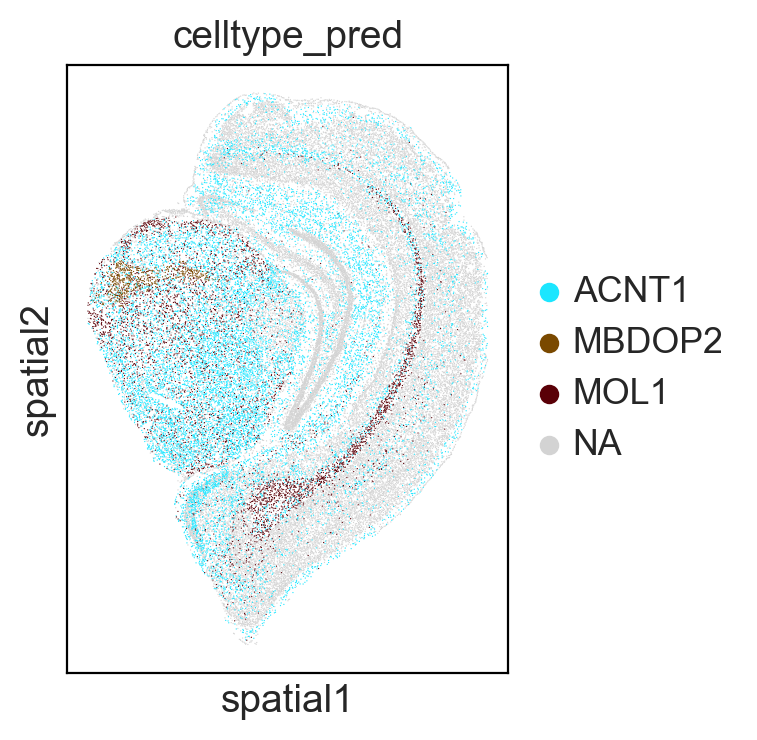

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


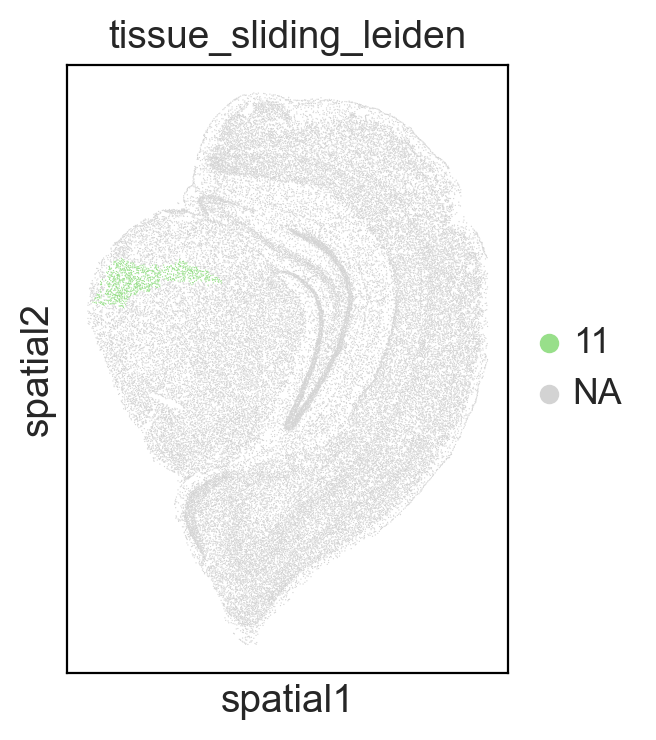

In [20]:
# plot cells of cluster 11 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster11 = adata[adata.obs[annotation_label] == stats.columns[1]].concatenate(adata[adata.obs[annotation_label] == stats.columns[8]]).concatenate(adata[adata.obs[annotation_label] == stats.columns[15]])
sc.pl.spatial(adata, groups=[stats.columns[1], stats.columns[8], stats.columns[15]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['11'], color='tissue_sliding_leiden', spot_size=30)

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


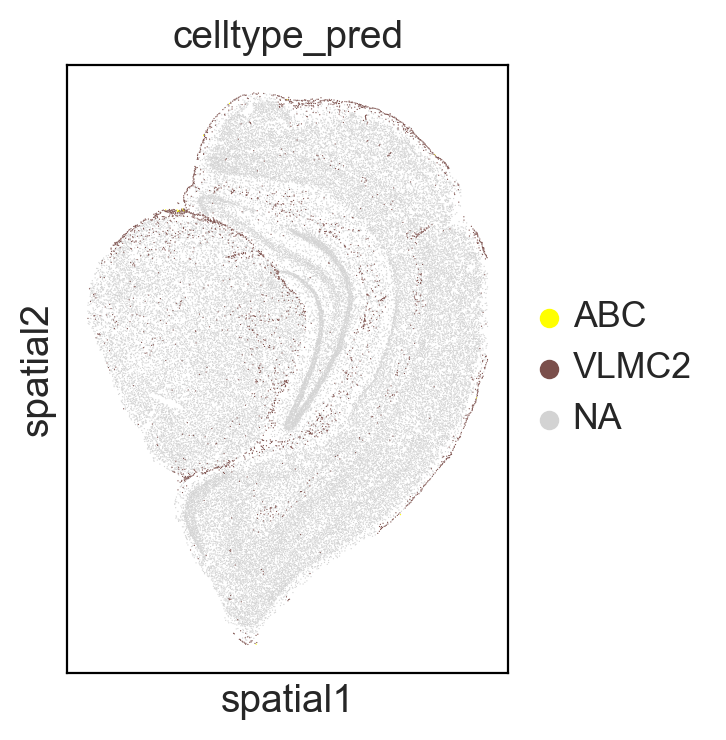

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


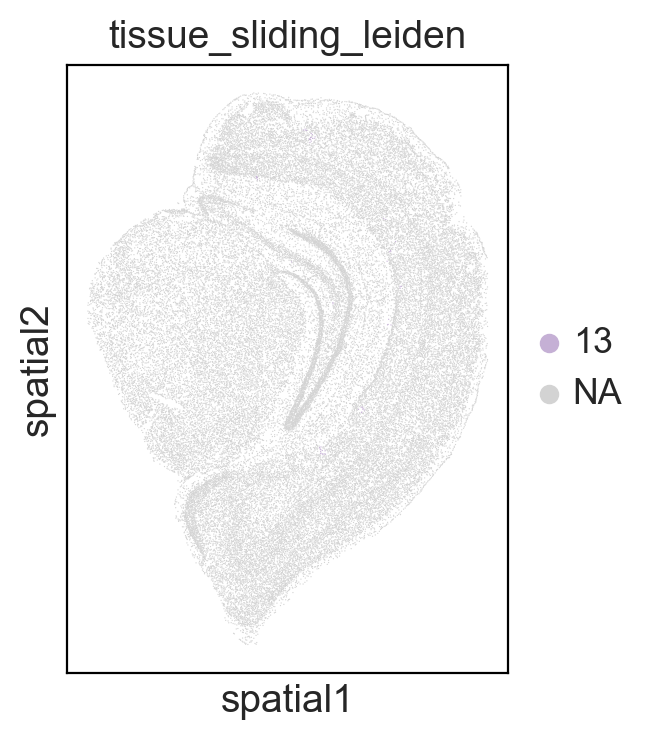

In [21]:
# plot cells of cluster 13 in original colors
sc.settings.set_figure_params(dpi=100, facecolor='white')
# cluster13 = adata[adata.obs[annotation_label] == stats.columns[0]].concatenate(adata[adata.obs[annotation_label] == stats.columns[33]])
sc.pl.spatial(adata, groups=[stats.columns[0], stats.columns[33]], color=annotation_label, spot_size=30)
sc.pl.spatial(adata, groups=['13'], color='tissue_sliding_leiden', spot_size=30)

# Entropy, scatteredness and other metrics
### --evaluated on cell centered windows of different sizes--

In [ ]:
import skimage.measure
import scipy.stats
import scipy.ndimage.measurements

def metrics_calculator(stats, annot_col, cell_row, win_size):
    # make win_size odd
    win_size= win_size+1 if np.mod(win_size,2)==0 else win_size
    # init cell image to win_size square
    cell_image = np.zeros(shape=(win_size, win_size), dtype=np.int32)
    # define the shiftf relative to cell position in order to more easily fill the cell_image
    comp_X = cell_row['Centroid_X'] - (win_size-1)/2
    comp_Y = cell_row['Centroid_Y'] - (win_size-1)/2
    # fill the image with cells
    left    = cell_row['Centroid_X'] - (win_size-1)/2
    right   = cell_row['Centroid_X'] + (win_size-1)/2
    bottom  = cell_row['Centroid_Y'] - (win_size-1)/2
    top     = cell_row['Centroid_Y'] + (win_size-1)/2
    cell_window = stats[(stats['Centroid_X']<=right)&(left<=stats['Centroid_X'])&(stats['Centroid_Y']<=top)&(bottom<=stats['Centroid_Y'])]
    for _, cell_pos in cell_window.iterrows():
        cell_image[int(cell_pos['Centroid_X']-comp_X), int(cell_pos['Centroid_Y']-comp_Y)] = 1
    # calculate metrics
    entropy2D = skimage.measure.shannon_entropy(cell_image)
    entropy1D = scipy.stats.entropy(cell_image.ravel(), base=2)
    entropy1Dexp = scipy.stats.entropy(cell_image.ravel())
    _, num_objects = scipy.ndimage.measurements.label(cell_image, structure=None, output=None) # this assumes 4 neighbors connectivity
    # idea for scatteredness was to compute the number of connected components and divide it with number of existing non-zero elements
    # but this measure does not contain the information on percentage of non-zero elements in the matrix.
    # thus we multiply it with non-zero percentage (num non-zero / total num) creating just this formula
    # num_object/image.size
    # max value is based on neighbors size (if 4 then 1/4, if 8, 1/8), min value is 0 if there are no non-zero elements
    scatteredness = num_objects/cell_image.size *4

    return list([entropy2D, scatteredness, entropy1D, entropy1Dexp])

In [ ]:
## Cao Lei's code for cell centered window analysis

# def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
#     left = row[1]['Centroid_X']+l*density_thred
#     right = row[1]['Centroid_X']+r*density_thred
#     up = row[1]['Centroid_Y']+u*density_thred
#     down = row[1]['Centroid_Y']+d*density_thred
#     #print(left, right, up, down)
#     tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
#     tmp = tmp.groupby(by=use_col).count()
#     return list(tmp['Centroid_X'])


    
    

def tissue_cluster_cell_res(adata1, use_col, win_size = 150, moran_thres = -1):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        # tmp = density_calculator(stats,use_col, row, bin_size/2, -1,1,1,-1)
        tmp = metrics_calculator(stats=stats, annot_col=use_col, cell_row=row[1], win_size=win_size)
        ret.append(tmp)
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = ['entropy2D', 'scatteredness', 'entropy1Dbase2', 'entropy1Dbasee']
    # ret.columns = [stats[use_col].cat.categories]
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    # sc.pp.neighbors(tissue, use_rep='spatial')
    # tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    # var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    # tissue.raw = tissue
    # tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=0.2)
    return tissue


In [ ]:
tissue = tissue_cluster_cell_res(adata, use_col=annotation_label, win_size = 100, moran_thres = -1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_13220/3833960188.py:25: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  _, num_objects = scipy.ndimage.measurements.label(cell_image, structure=None, output=None) # this assumes 4 neighbors connectivity
C:\Users\mejas\AppData\Local\Temp/ipykernel_13220/2482845508.py:33: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


In [ ]:
tissue.var_names

Index(['entropy2D', 'scatteredness', 'entropy1Dbase2', 'entropy1Dbasee'], dtype='object')

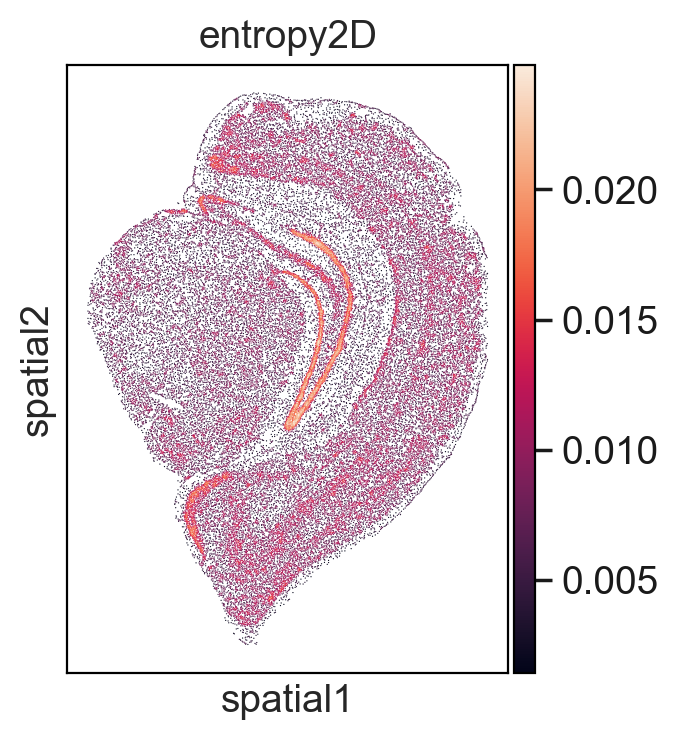

In [ ]:
sc.pl.spatial(tissue, color="entropy2D", spot_size=30)

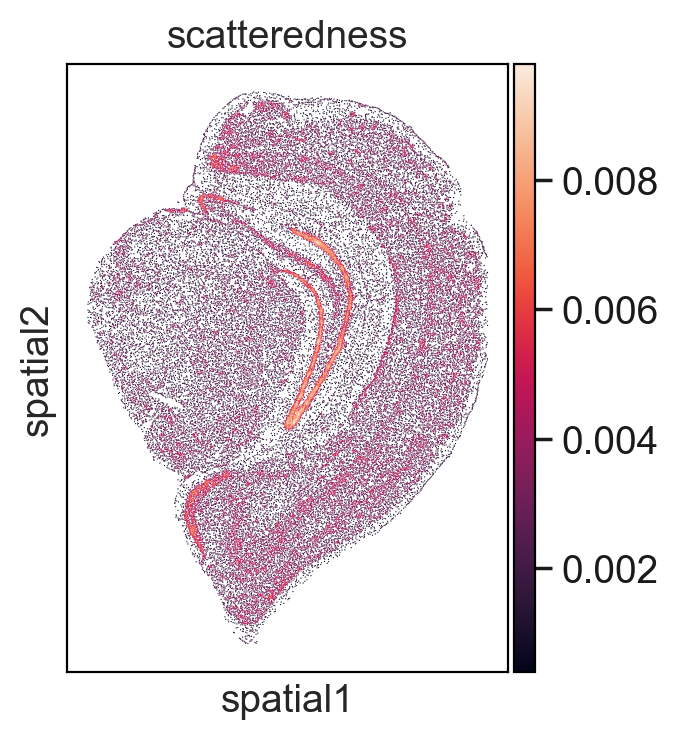

In [ ]:
sc.pl.spatial(tissue, color="scatteredness", spot_size=30)

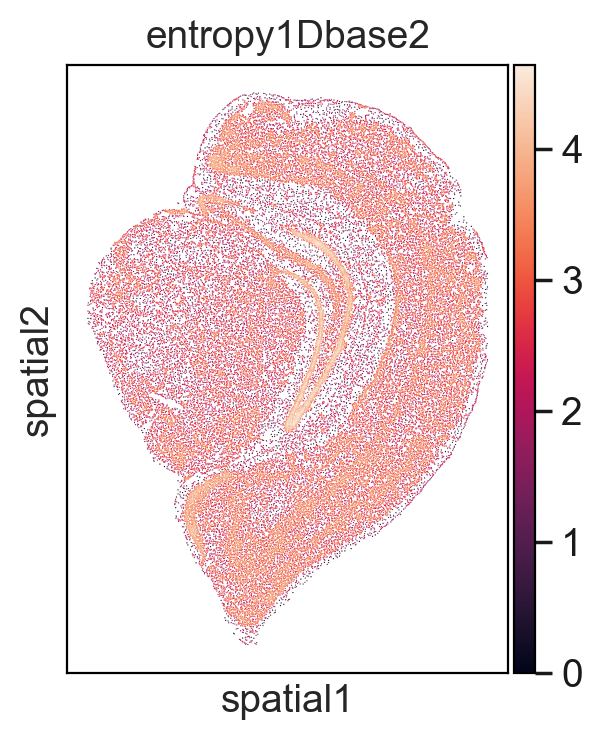

In [ ]:
sc.pl.spatial(tissue, color="entropy1Dbase2", spot_size=30)

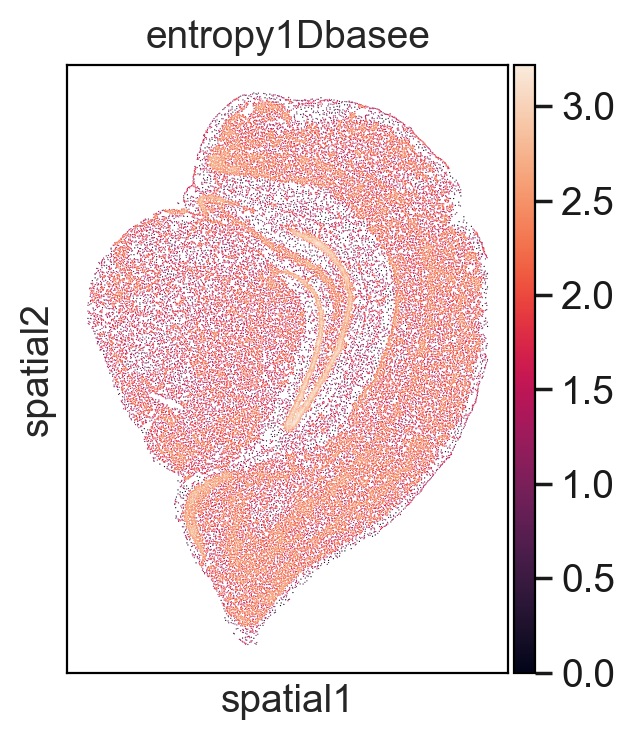

In [91]:
sc.pl.spatial(tissue, color="entropy1Dbasee", spot_size=30)

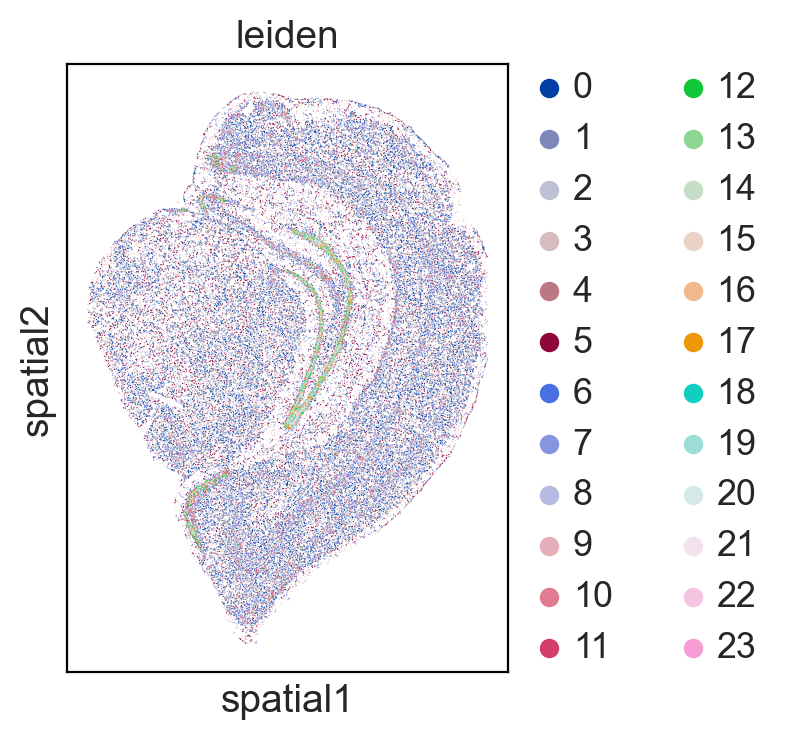

In [94]:
sc.pl.spatial(tissue, color="leiden", spot_size=30)

# Co-occurence max voting

In [8]:
# pd.options.mode.chained_assignment = None  # default='warn'

In [80]:
def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
    left = row[1]['Centroid_X']+l*density_thred
    right = row[1]['Centroid_X']+r*density_thred
    up = row[1]['Centroid_Y']+u*density_thred
    down = row[1]['Centroid_Y']+d*density_thred
    #print(left, right, up, down)
    tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
    tmp = tmp.groupby(by=use_col).count()
    return list(tmp['Centroid_X'])
    

def tissue_max_voting_cluster_cell_res(adata1, use_col, win_size = 200, moran_thres = 0.0, resolution=0.2, vote_win_size=None):
    vote_win_size = win_size if vote_win_size==None else vote_win_size
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        tmp = density_calculator(stats,use_col, row, win_size/2, -1,1,1,-1)
        # normalize cell count by total cell num
        tmp = tmp/np.sum(tmp)*1000
        ret.append(tmp.astype(int))
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = stats[use_col].cat.categories
    tissue = AnnData(ret, dtype=np.int64)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    # sc.pp.neighbors(tissue, use_rep='spatial')
    # tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    # var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    # tissue.raw = tissue
    # tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=resolution)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])


    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the center of the cell
        left    = x_curr - (vote_win_size-1)/2
        right   = x_curr + (vote_win_size-1)/2
        bottom  = y_curr - (vote_win_size-1)/2
        top     = y_curr + (vote_win_size-1)/2
        cell_window = tissue.obs['leiden'][(tissue.obsm['spatial'][:,0]<=right)&(left<=tissue.obsm['spatial'][:,0])&(tissue.obsm['spatial'][:,1]<=top)&(bottom<=tissue.obsm['spatial'][:,1])]
        # max vote
        # max vote should be saved in a new obs column so that it does not have ghost effect on
        # other labels during refinment
        tissue.obs.loc[(tissue.obsm['spatial'][:,0] == x_curr) & (tissue.obsm['spatial'][:,1] == y_curr), 'leiden_refined'] = cell_window.mode()[0]

    
    

    return tissue



In [81]:
tissue = tissue_max_voting_cluster_cell_res(adata, use_col=annotation_label, win_size = 150, moran_thres = -1, resolution = 0.005, vote_win_size = 50)

In [82]:
diverging_color_palette = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4','#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837', '#8c510a','#d8b365','#f6e8c3','#c7eae5','#5ab4ac','#01665e', '#b2182b','#ef8a62','#fddbc7','#e0e0e0','#999999','#4d4d4d'] 

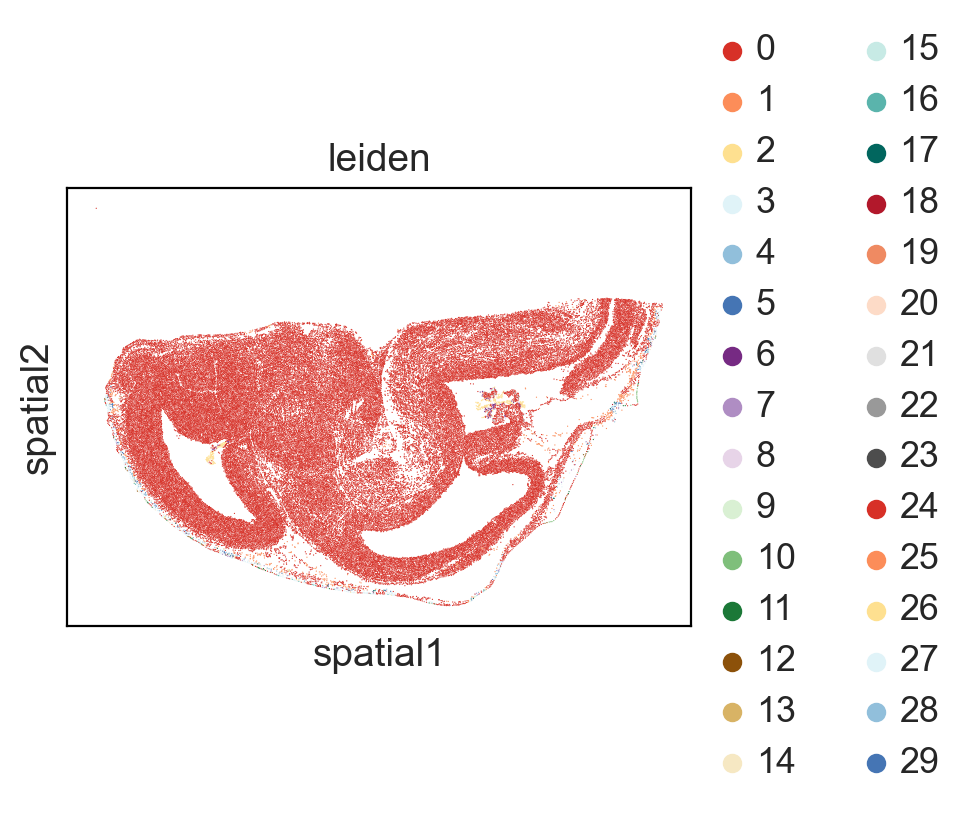

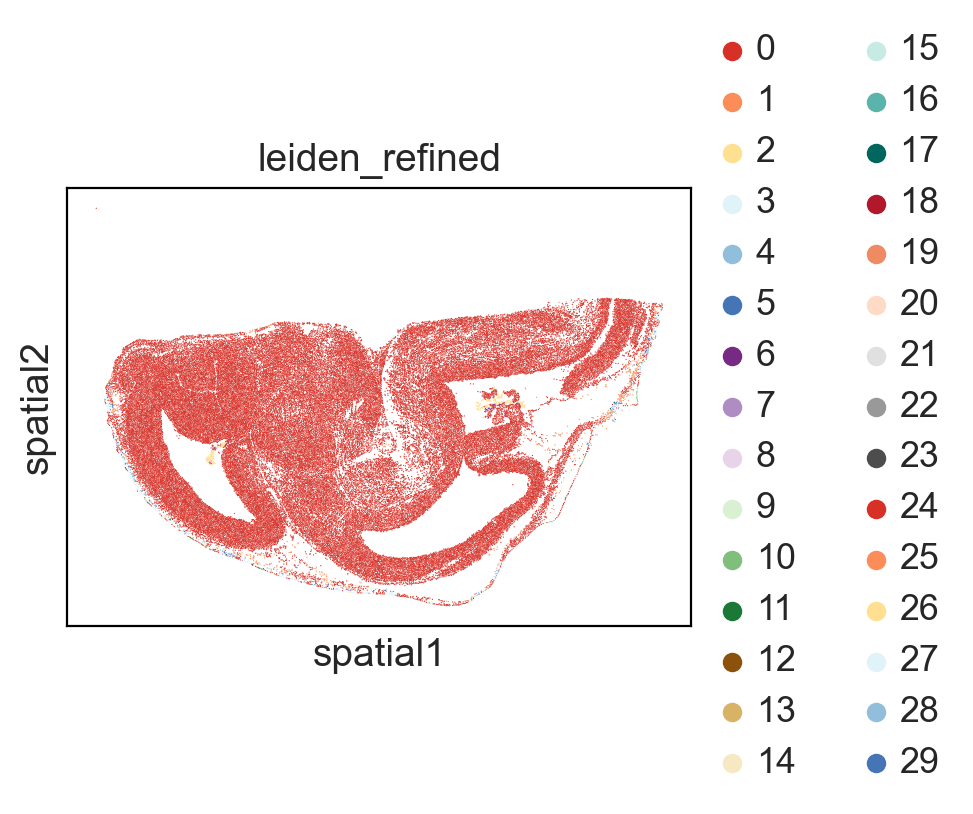

In [83]:
sc.pl.spatial(tissue, color='leiden', palette=diverging_color_palette, spot_size=30)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', palette=diverging_color_palette, spot_size=30)

In [84]:
adata.obs['tissue_sliding_leiden'] = tissue.obs['leiden_refined']

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


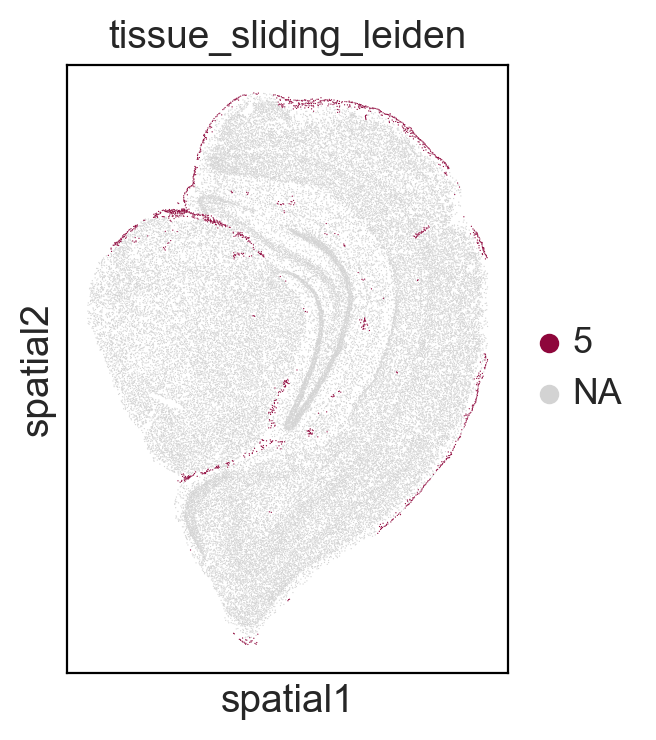

In [43]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

sc.pl.spatial(adata, groups=['5'], color='tissue_sliding_leiden', spot_size=30)